In [ ]:
import numpy as np
import tensorflow as tf
import itertools
from sklearn.metrics import confusion_matrix
from scipy.stats import chi2_contingency
from math import log, sqrt, exp

# 감정 레이블 정의
emotion_labels = {
    "happy": 0, "sad": 1, "anger": 2, "surprise": 3,
    "disgust": 4, "neutral": 5, "fear": 6,
}

# 랜드마크 인덱스 정의
landmark_indices = [70, 63, 105, 66, 107, 55, 65, 52, 53, 46, 300, 293, 334, 296, 336, 285, 295, 282, 283, 276, 33, 246, 161, 160, 159, 158, 157, 173, 133, 155, 154, 153, 145, 144, 163, 7, 263, 466, 388, 387, 386, 385, 384, 398, 362, 382, 381, 380, 374, 373, 390, 249, 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 308, 324, 318, 402, 317, 14, 87, 178, 88, 95, 61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291, 375, 321, 405, 314, 17, 84, 181, 91, 146, 64, 4, 294, 168, 6, 197, 195, 5, 1]

# 랜드마크 추출 함수
def extract_selected_landmarks(landmarks):
    selected_landmarks = tf.gather(landmarks, indices=landmark_indices, axis=0)
    return tf.reshape(selected_landmarks, [len(landmark_indices) * 3])

# Z 값 조합 계산 함수
def calculate_z_value_combinations(z_values):
    z_combinations = list(itertools.combinations(range(8), 3))
    z_product_combinations = []

    for indices in z_combinations:
        selected_values = tf.gather(z_values, indices)
        product = tf.reduce_prod(selected_values)
        z_product_combinations.append(product)

    return tf.stack(z_product_combinations)

# TFRecord 파싱 함수
def parse_and_prepare_tfrecord(tfrecord):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "landmarks": tf.io.VarLenFeature(tf.float32),
        "label": tf.io.FixedLenFeature([], tf.int64),
        "z_values": tf.io.FixedLenFeature([8], tf.float32),
    }
    parsed_features = tf.io.parse_single_example(tfrecord, features)

    image = tf.io.decode_jpeg(parsed_features["image"])
    image = tf.image.resize(image, [48, 48])
    image = tf.image.rgb_to_grayscale(image)
    image = tf.expand_dims(image, -1)
    image = tf.squeeze(image, axis=-1)

    landmarks = tf.sparse.to_dense(parsed_features["landmarks"])
    landmarks = tf.reshape(landmarks, [-1, 3])
    selected_landmarks = extract_selected_landmarks(landmarks)
    selected_landmarks.set_shape([303])

    label = tf.one_hot(parsed_features["label"], depth=len(emotion_labels))

    z_values = parsed_features["z_values"]
    z_product_combinations = calculate_z_value_combinations(z_values)

    return (image, selected_landmarks, z_product_combinations), label

# 데이터셋 로드 및 준비 함수
def load_and_prepare_dataset(tfrecord_file, batch_size=None):
    dataset = tf.data.TFRecordDataset(tfrecord_file)
    dataset = dataset.map(parse_and_prepare_tfrecord)
    if batch_size is not None:
        dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_tfrecord_file = "/content/drive/MyDrive/clean_0317/Dataset_clean/clean_YES_Z_train.tfrecord"
val_tfrecord_file = "/content/drive/MyDrive/clean_0317/Dataset_clean/clean_YES_Z_val.tfrecord"
test_tfrecord_file = "/content/drive/MyDrive/clean_0317/Dataset_clean/clean_YES_Z_test.tfrecord"

train_dataset = load_and_prepare_dataset(train_tfrecord_file, 16)
val_dataset = load_and_prepare_dataset(val_tfrecord_file, 16)
test_dataset = load_and_prepare_dataset(test_tfrecord_file, 16)

# 모델 불러오기
model = tf.keras.models.load_model('/content/drive/MyDrive/clean_0317/gan1_clean_0407_combined_model.h5')

# 예측 수행
all_predictions = []
all_true_labels = []
for batch in test_dataset:
    inputs, true_labels = batch
    predictions = model.predict(inputs)

    # 예측된 클래스
    predicted_classes = np.argmax(predictions, axis=1)
    # 실제 클래스 (원-핫 인코딩에서 가장 높은 값을 가진 인덱스)
    true_classes = np.argmax(true_labels, axis=1)

    all_predictions.extend(predicted_classes)
    all_true_labels.extend(true_classes)

# 감정별 Odds ratio 계산
# 모든 예측과 실제 레이블에 대해 계산을 진행합니다.
for emotion, idx in emotion_labels.items():
    TP = np.sum((np.array(all_predictions) == idx) & (np.array(all_true_labels) == idx))
    FP = np.sum((np.array(all_predictions) == idx) & (np.array(all_true_labels) != idx))
    FN = np.sum((np.array(all_predictions) != idx) & (np.array(all_true_labels) == idx))
    TN = np.sum((np.array(all_predictions) != idx) & (np.array(all_true_labels) != idx))

    # Odds Ratio 계산
    if TP == 0 or TN == 0 or FP == 0 or FN == 0:
        TP += 1
        FP += 1
        FN += 1
        TN += 1

    odds_ratio = (TP * TN) / (FP * FN)

    # 신뢰 구간 계산 및 P-value 추가
    se = sqrt(1/TP + 1/TN + 1/FP + 1/FN)
    z = 1.96  # 95% 신뢰 수준에 해당하는 z 값
    log_or = log(odds_ratio)
    ci_lower = exp(log_or - z * se)
    ci_upper = exp(log_or + z * se)

    _, p_value, _, _ = chi2_contingency([[TP, FP], [FN, TN]])

    print(f"{emotion}에 대한 Odds Ratio: {odds_ratio}, 95% CI: ({ci_lower}, {ci_upper}), P-value: {p_value}")


1/1 [==============================] - 0s 23ms/step
happy에 대한 Odds Ratio: 186.8995765275257, 95% CI: (142.4289077926798, 245.25535052908526), P-value: 0.0
sad에 대한 Odds Ratio: 11.5108832502058, 95% CI: (9.29863858533097, 14.249444365855236), P-value: 1.3737945026900123e-151
anger에 대한 Odds Ratio: 11.256264968748175, 95% CI: (9.366962246343133, 13.526637314688921), P-value: 2.5860424767387085e-190
surprise에 대한 Odds Ratio: 20.40599134330625, 95% CI: (15.915990885448517, 26.162648979888203), P-value: 1.972678220800905e-202
disgust에 대한 Odds Ratio: 2.7388222683727474, 95% CI: (1.95350397767525, 3.839842408030883), P-value: 2.526239028412421e-09
neutral에 대한 Odds Ratio: 7.933705638623671, 95% CI: (6.602740344839766, 9.532963871511523), P-value: 1.82679477684398e-132
fear에 대한 Odds Ratio: 5.4693903557956975, 95% CI: (3.779511251585339, 7.9148410661625315), P-value: 4.525700941384633e-23


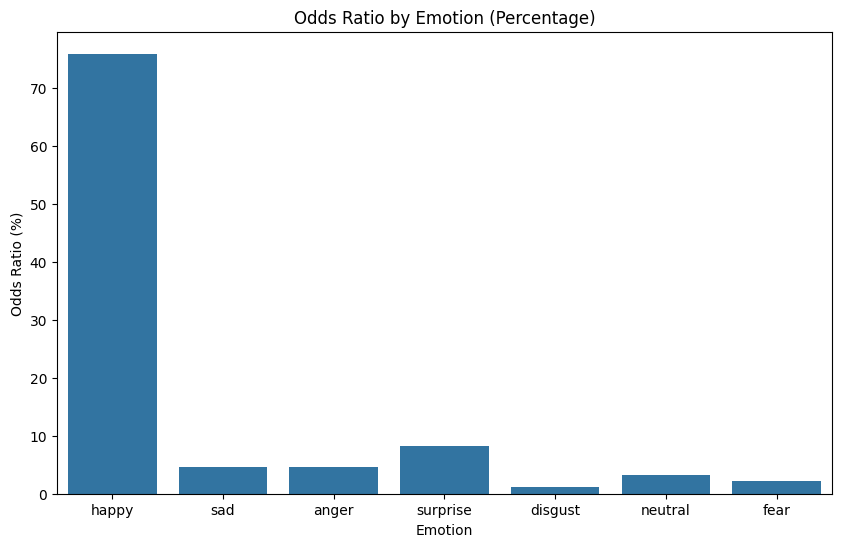

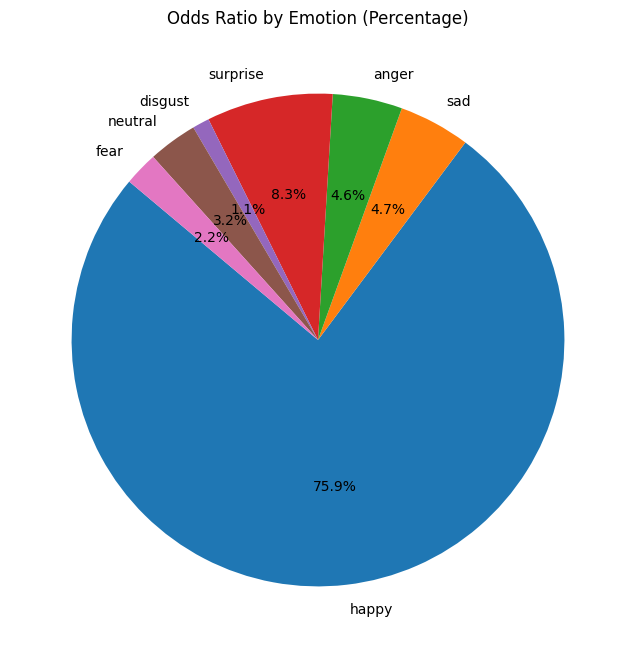

In [ ]:
# 시각화
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 감정별 Odds Ratio 결과
emotion_labels = ["happy", "sad", "anger", "surprise", "disgust", "neutral", "fear"]
odds_ratios = [186.8995765275257, 11.5108832502058, 11.256264968748175, 20.40599134330625, 2.7388222683727474, 7.933705638623671, 5.4693903557956975]

# Odds Ratio를 백분율로 변환
odds_ratios_percent = [(or_val / sum(odds_ratios)) * 100 for or_val in odds_ratios]

# 막대그래프
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_labels, y=odds_ratios_percent)
plt.title('Odds Ratio by Emotion (Percentage)')
plt.xlabel('Emotion')
plt.ylabel('Odds Ratio (%)')
plt.savefig('odds_ratio_bar_plot.png')
plt.show()

# 원그래프
plt.figure(figsize=(8, 8))
plt.pie(odds_ratios_percent, labels=emotion_labels, autopct='%1.1f%%', startangle=140)
plt.title('Odds Ratio by Emotion (Percentage)')
plt.savefig('odds_ratio_pie_chart.png')
plt.show()
